In [1]:
import os, sys
sys.path.append("yamnet/")
from tools import *

In [2]:
sr = 22050
model = modelYamnet(sr=sr)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
wav_file_name = 'music/Stranger Things (Extended).mp3'
wav_data, sr = load(wav_file_name)

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [11]:
import features as features_lib

spectrogram = features_lib.waveform_to_log_mel_spectrogram(
        tf.squeeze([wav_data], axis=0), params)
patches = features_lib.spectrogram_to_patches(spectrogram, params)

In [12]:
patches.shape

TensorShape([3255, 96, 64])

In [4]:
np.reshape(wav_data, [1, -1]).shape

(1, 7182144)

In [16]:
wav_file_name = 'music/Stranger Things (Extended).mp3'
wav_data, scores, spectrogram = model.predict_music(wav_file_name)

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [ ]:
ipd.Audio(wav_data.T, rate=sr)

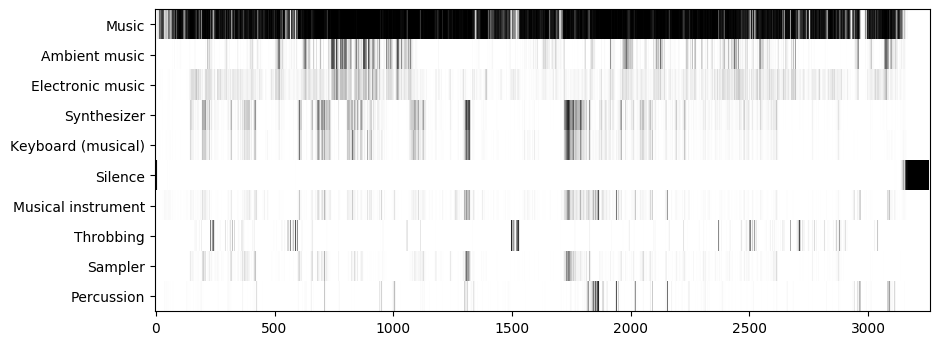

In [8]:
draw_prediction(model.class_names, scores)

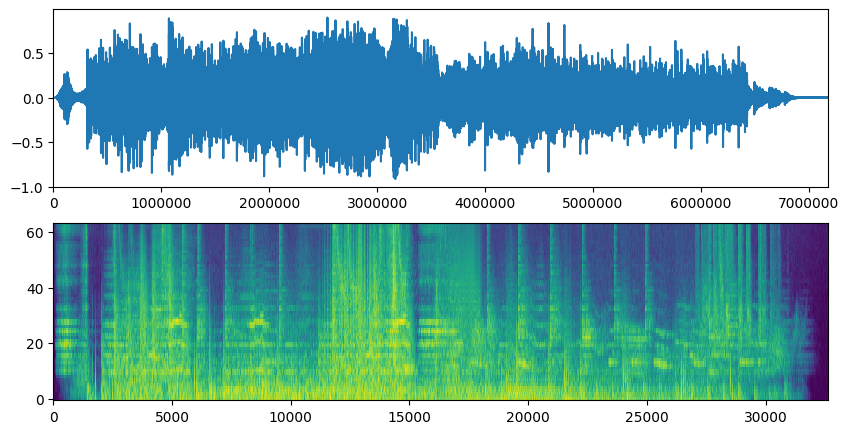

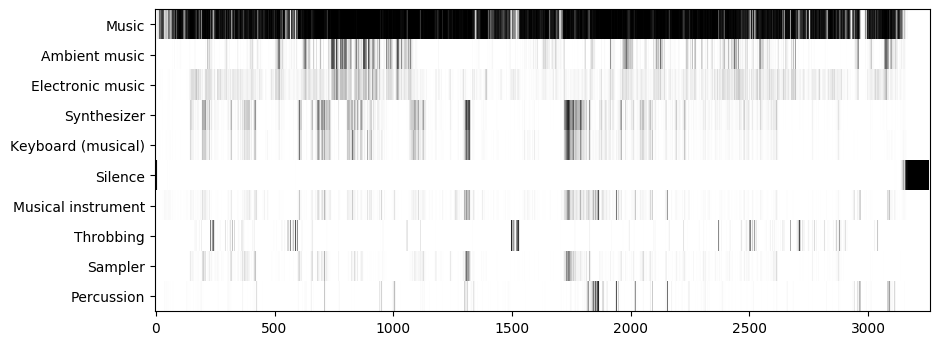

In [17]:
draw_result(wav_data, model.class_names, scores, spectrogram)